In [3]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader,Dataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Pre-processing steps

In [6]:
df=pd.read_csv('Dataset.csv')
df.columns=["Text", "Sentiment"]
#Removing Stopwords
stop_words = stopwords.words('english')
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#Stemming
ps = PorterStemmer()

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [ps.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df['Text'] = df['Text'].apply(stem_sentences)
df['Sentiment'] = df['Sentiment'].replace(-1,0)

TF-IDF + Neural Network

In [4]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = TfidfVectorizer()
        self.sequences= self.vectorizer.fit_transform(data.Text.tolist())
        self.labels=data.Sentiment.tolist()
        self.token2idx=self.vectorizer.vocabulary_
        self.idx2token={idx: token for token, idx in self.token2idx.items()}
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [5]:
#Split dataset
df_train=df.head(4630) 
df_test=df.tail(1150) 

dataset=Sequences(df_train)
train_loader=DataLoader(dataset,batch_size=4630)

In [6]:
class TfIdfNN(nn.Module):
  def __init__(self,vocab_size,hidden1,hidden2):
    super().__init__()
    ###1st hidden
    self.linear_1=nn.Linear(vocab_size,hidden1)
    self.relu_1=nn.ReLU()

    #2nd hidden
    self.linear_2=nn.Linear(vocab_size,hidden2)
    self.relu_2=nn.ReLU()

    #output
    self.linear_out=nn.Linear(hidden2,1)

  def forward(self,inputs):
    #1st hidden
    out=self.linear_1(inputs.squeeze(1).float())
    out=self.relu_1(out)

    #2nd hidden
    out=self.linear_2(inputs.squeeze(1).float())
    out=self.relu_2(out)

    #Linear layout
    logits=self.linear_out(out)

    return logits

In [7]:
model=TfIdfNN(len(dataset.token2idx),100,50)

In [8]:
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=0.01)

In [9]:
train_losses=[]

for epoch in range(150):
  losses=[]
  total=0
  for inputs,target in train_loader:
      model.zero_grad()

      output=model(inputs)
      loss=criterion(output.squeeze(),target.float())

      loss.backward()

      optimizer.step()

      losses.append(loss.item())
      total+=1

  epoch_loss=sum(losses)/total
  train_losses.append(epoch_loss)

  print(f'Epoch #{epoch+1}\tTrain Loss: {epoch_loss:.3f}')


Epoch #1	Train Loss: 0.686
Epoch #2	Train Loss: 0.666
Epoch #3	Train Loss: 0.643
Epoch #4	Train Loss: 0.617
Epoch #5	Train Loss: 0.588
Epoch #6	Train Loss: 0.559
Epoch #7	Train Loss: 0.529
Epoch #8	Train Loss: 0.499
Epoch #9	Train Loss: 0.470
Epoch #10	Train Loss: 0.441
Epoch #11	Train Loss: 0.412
Epoch #12	Train Loss: 0.384
Epoch #13	Train Loss: 0.355
Epoch #14	Train Loss: 0.327
Epoch #15	Train Loss: 0.300
Epoch #16	Train Loss: 0.275
Epoch #17	Train Loss: 0.251
Epoch #18	Train Loss: 0.230
Epoch #19	Train Loss: 0.210
Epoch #20	Train Loss: 0.192
Epoch #21	Train Loss: 0.174
Epoch #22	Train Loss: 0.159
Epoch #23	Train Loss: 0.144
Epoch #24	Train Loss: 0.131
Epoch #25	Train Loss: 0.119
Epoch #26	Train Loss: 0.109
Epoch #27	Train Loss: 0.100
Epoch #28	Train Loss: 0.092
Epoch #29	Train Loss: 0.085
Epoch #30	Train Loss: 0.078
Epoch #31	Train Loss: 0.072
Epoch #32	Train Loss: 0.066
Epoch #33	Train Loss: 0.061
Epoch #34	Train Loss: 0.057
Epoch #35	Train Loss: 0.053
Epoch #36	Train Loss: 0.049
E

In [10]:
def predict_sentiment(text):
  test_vector= torch.LongTensor(dataset.vectorizer.transform([text]).toarray())
  output=model(test_vector)
  prediction=torch.sigmoid(output).item()

  if prediction > 0.5:
    return 1
  else:
    return 0

In [11]:
pred_labels=[]

sentences=list(df_test['Text'])
labels=df_test['Sentiment']

for sentence in sentences:
  pred_labels.append(predict_sentiment(sentence))

accuracy=accuracy_score(labels,pred_labels)
precision=precision_score(labels,pred_labels)
recall=recall_score(labels,pred_labels)
f1=f1_score(labels,pred_labels)
print('Accuracy: %f' % accuracy)
print('precision: %f' % precision)
print('recall: %f' % recall)
print('f1: %f' % f1)

Accuracy: 0.473913
precision: 0.472997
recall: 1.000000
f1: 0.642224


In [19]:
import numpy as np

result=np.array(list([accuracy,precision,recall,f1]))
np.save("result.npy",result)

In [7]:
result=np.load("result.npy",allow_pickle=True)
ac=result[0]
pr=result[1]
rec=result[2]
f1=result[3]

In [25]:
rec

1.0

array([0.47391304, 0.47299652, 1.        , 0.64222354])

BOW+Neural Network

In [4]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer()
        self.sequences= self.vectorizer.fit_transform(data.Text.tolist())
        self.labels=data.Sentiment.tolist()
        self.token2idx=self.vectorizer.vocabulary_
        self.idx2token={idx: token for token, idx in self.token2idx.items()}
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [8]:
#Split dataset
df_train=df.head(4630) 
df_test=df.tail(1150)
dataset=Sequences(df_train)
'''dataset.vectorizer = CountVectorizer()
dataset.sequences= dataset.vectorizer.fit_transform(df_train.Text.tolist())
dataset.labels=df_train.Sentiment.tolist()
dataset.token2idx=dataset.vectorizer.vocabulary_
dataset.idx2token={idx: token for token, idx in dataset.token2idx.items()}'''
train_loader=DataLoader(dataset,batch_size=4630)

In [9]:
class CVNN(nn.Module):
  def __init__(self,vocab_size,hidden1,hidden2):
    super().__init__()
    ###1st hidden
    self.linear_1=nn.Linear(vocab_size,hidden1)
    self.relu_1=nn.ReLU()

    #2nd hidden
    self.linear_2=nn.Linear(vocab_size,hidden2)
    self.relu_2=nn.ReLU()

    #output
    self.linear_out=nn.Linear(hidden2,1)

  def forward(self,inputs):
    #1st hidden
    out=self.linear_1(inputs.squeeze(1).float())
    out=self.relu_1(out)

    #2nd hidden
    out=self.linear_2(inputs.squeeze(1).float())
    out=self.relu_2(out)

    #Linear layout
    logits=self.linear_out(out)

    return logits

In [10]:
model=CVNN(len(dataset.token2idx),100,50)
'''model.linear_1=nn.Linear(len(dataset.token2idx),100)
model.relu_1=nn.ReLU()
#2nd hidden
model.linear_2=nn.Linear(len(dataset.token2idx),50)
model.relu_2=nn.ReLU()
#output
model.linear_out=nn.Linear(50,1)'''

'model.linear_1=nn.Linear(len(dataset.token2idx),100)\nmodel.relu_1=nn.ReLU()\n#2nd hidden\nmodel.linear_2=nn.Linear(len(dataset.token2idx),50)\nmodel.relu_2=nn.ReLU()\n#output\nmodel.linear_out=nn.Linear(50,1)'

In [11]:
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=0.01)

In [12]:
train_losses=[]

for epoch in range(150):
  losses=[]
  total=0
  for inputs,target in train_loader:
      model.zero_grad()

      output=model(inputs)
      loss=criterion(output.squeeze(),target.float())

      loss.backward()

      optimizer.step()

      losses.append(loss.item())
      total+=1

  epoch_loss=sum(losses)/total
  train_losses.append(epoch_loss)

  print(f'Epoch #{epoch+1}\tTrain Loss: {epoch_loss:.3f}')


Epoch #1	Train Loss: 0.692
Epoch #2	Train Loss: 0.649
Epoch #3	Train Loss: 0.603
Epoch #4	Train Loss: 0.557
Epoch #5	Train Loss: 0.511
Epoch #6	Train Loss: 0.465
Epoch #7	Train Loss: 0.419
Epoch #8	Train Loss: 0.372
Epoch #9	Train Loss: 0.328
Epoch #10	Train Loss: 0.289
Epoch #11	Train Loss: 0.257
Epoch #12	Train Loss: 0.230
Epoch #13	Train Loss: 0.205
Epoch #14	Train Loss: 0.180
Epoch #15	Train Loss: 0.158
Epoch #16	Train Loss: 0.139
Epoch #17	Train Loss: 0.124
Epoch #18	Train Loss: 0.111
Epoch #19	Train Loss: 0.099
Epoch #20	Train Loss: 0.089
Epoch #21	Train Loss: 0.080
Epoch #22	Train Loss: 0.072
Epoch #23	Train Loss: 0.065
Epoch #24	Train Loss: 0.059
Epoch #25	Train Loss: 0.054
Epoch #26	Train Loss: 0.049
Epoch #27	Train Loss: 0.044
Epoch #28	Train Loss: 0.040
Epoch #29	Train Loss: 0.037
Epoch #30	Train Loss: 0.034
Epoch #31	Train Loss: 0.031
Epoch #32	Train Loss: 0.028
Epoch #33	Train Loss: 0.026
Epoch #34	Train Loss: 0.024
Epoch #35	Train Loss: 0.022
Epoch #36	Train Loss: 0.020
E

In [13]:
def predict_sentiment(text):
  test_vector= torch.LongTensor(dataset.vectorizer.transform([text]).toarray())
  output=model(test_vector)
  prediction=torch.sigmoid(output).item()

  if prediction > 0.5:
    return 1
  else:
    return 0

In [15]:

pred_labels=[]

sentences=list(df_test['Text'])
labels=df_test['Sentiment']

for sentence in sentences:
  pred_labels.append(predict_sentiment(sentence))

accuracy2=accuracy_score(labels,pred_labels)
precision2=precision_score(labels,pred_labels)
recall2=recall_score(labels,pred_labels)
f12=f1_score(labels,pred_labels)
print('Accuracy: %f' % accuracy2)
print('precision: %f' % precision2)
print('recall: %f' % recall2)
print('f1: %f' % f12)

Accuracy: 0.577391
precision: 0.532646
recall: 0.856354
f1: 0.656780


([<matplotlib.axis.XTick at 0x7f456a2447d0>,
 [Text(0, 0, 'Neural Network with BoW'),
  Text(0, 0, 'Neural Network with Tf-Idf')])

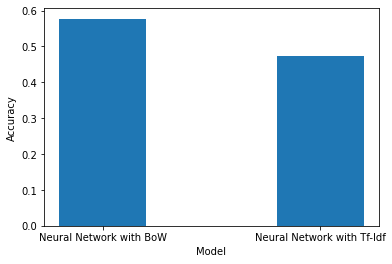

In [20]:
import matplotlib.pyplot as plt
x=["Neural Network with BoW","Neural Network with Tf-Idf"]
w=0.4
Ac=[accuracy2,ac]
bar1=np.arange(len(x))
plt.bar(bar1,Ac,w,label="Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(bar1,x)

In [ ]:
results=[]
results.append(accuracy)
results.append(precision)
results.append(recall)
results.append(f1)
results.append(accuracy2)
results.append(precision2)
results.append(recall2)
results.append(f12)
results

One-Hot Embedding + CNN

In [ ]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(binary=True)
        self.sequences= self.vectorizer.fit_transform(data.Text.tolist())
        self.labels=data.Sentiment.tolist()
        self.token2idx=self.vectorizer.vocabulary_
        self.idx2token={idx: token for token, idx in self.token2idx.items()}
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [ ]:
#Split dataset
df_train=df.head(4630) 
df_test=df.tail(1150) 

dataset=Sequences(df_train)
train_loader=DataLoader(dataset,batch_size=4630)

In [ ]:
class cnn(nn.Module):
    def __init__(self, input_dim):
        super(cnn, self).__init__()
        self.cnn_layer_1 = nn.Conv1d(in_channels=1, out_channels=256,kernel_size=3, stride=1)
        self.cnn_layer_2 = nn.Conv1d(in_channels=256, out_channels=32,kernel_size=3, stride=1)
        
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool1d(2)
        
        self.linear_layer_1 = nn.Linear(32*148*148, 512)  #1200 * 512
        self.linear_layer_2 = nn.Linear(512, 128) # 512*128
        self.linear_layer_3 = nn.Linear(128, 1)   #128*1
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(.2)
        # self.flatten = nn.Flatten()
        
    def forward(self, x):

        x = self.cnn_layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        print(x.shape)
        
        x = self.cnn_layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        print(x.shape)
        
        x = self.flatten(x)
        print(x.shape)
        
        x = self.linear_layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        x = self.linear_layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        x = self.linear_layer_3(x)
        logits = self.sigmoid(x)
        return logits

In [ ]:
model = cnn(len(dataset.token2idx))

In [ ]:
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=0.01)

In [ ]:
train_losses=[]

for epoch in range(15):
  losses=[]
  total=0
  for inputs,target in train_loader:
      model.zero_grad()
      
      output=model(inputs.type(torch.FloatTensor))
      loss=criterion(output.squeeze(),target.float())

      loss.backward()

      optimizer.step()

      losses.append(loss.item())
      total+=1

  epoch_loss=sum(losses)/total
  train_losses.append(epoch_loss)

  print(f'Epoch #{epoch+1}\tTrain Loss: {epoch_loss:.3f}')

In [ ]:
def testModel(model, loss_fn):
    model.eval()

    size = test.shape[0]

    loss = 0
    with torch.no_grad():
      for i in range(test.shape[0]):
        x, y = torch.reshape(test[i],(1,3,600,600)), torch.tensor([test_y[i]], dtype=torch.float)
    
        # Compute prediction error
        pred = model(x)[0]
        loss += loss_fn(pred, y).item()
      
    loss /= size
    
    print(f'Testing Loss: {loss}')

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    trainModel(model, loss_fn, optimizer)
    testModel(model, loss_fn)
print("Done!")